In [1]:
'''Interactive run file for the G2-structure learning'''
#...ensure this notebook is using the correct kernel for your virtual environment
# Import libraries
import os
import yaml
import numpy as np
import tensorflow as tf

# Import functions
from models.model import (
    GlobalModel, TrainingModel, NormalisationLayer, 
    DenormalisationLayer, NormalisedModel, ScaledGlorotUniform
)
from sampling.sampling import LinkSample
from geometry.compression import form_to_vec, vec_to_form, vec_to_metric
from geometry.geometry import exterior_derivative, holomorphic_volume_form_to_real
from geometry.wedge_product import wedge_product
from geometry.patches import patch_indices_to_scalar

# Print the hyperparameters
with open(os.getcwd()+'/hyperparameters/hps.yaml', "r") as file:
    hp = yaml.safe_load(file)
print(f'Run hyperparameters:\t...edit in hyperparameters/hps.yaml\n{hp}')

Run hyperparameters:	...edit in hyperparameters/hps.yaml
{'metric': False, 'num_samples': 200000, 'saved_model': False, 'saved_model_path': '...', 'n_hidden': 128, 'n_layers': 4, 'activations': 'gelu', 'use_bias': True, 'parameter_initialisation_scale': 1.0, 'embedding_dim': 8, 'epochs': 200, 'batch_size': 32, 'init_learning_rate': 0.001, 'min_learning_rate': 0.0001, 'validate': True, 'val_print': False, 'num_val_samples': 500, 'val_batch_size': 100, 'verbosity': 1, 'print_losses': False, 'print_interval': 1}


In [ ]:
# Run the training script
model_name = 'test'
!python3 -m run {model_name}

In [2]:
# Import the trained model
loaded_model_name = '3form' #model_name #...or set to desired name if not model trained above
loaded_model_path = os.getcwd() + f"/runs/global_model_{loaded_model_name}.keras" #...reimport the model
#loaded_model_path = os.getcwd() + f"/models/link_models/global_model_3form.keras" #...import a pre-trained model instead

# Custom objects for loading the new architecture
custom_objects = {
    'GlobalModel': GlobalModel,
    'NormalisationLayer': NormalisationLayer,
    'DenormalisationLayer': DenormalisationLayer,
    'NormalisedModel': NormalisedModel,
    'ScaledGlorotUniform': ScaledGlorotUniform
}

# Load the model
loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects=custom_objects)

/Users/ed/miniforge3/envs/cymetric/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer ScaledGlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [3]:
# Test loaded model on fake link points
# Testing hyperparameters
testsize = 1000 #...how many link points to use in the testing

# Generate the testing data on the Link
test_dataset = LinkSample(testsize)
test_linkpts = test_dataset.link_points()
test_patch_idxs = patch_indices_to_scalar(test_dataset.one_idxs, test_dataset.dropped_idxs)
if not hp["metric"]:
    test_link_outputs = test_dataset.g2_form
else:
    test_link_outputs = test_dataset.g2_metric
test_linkpts_tf = tf.convert_to_tensor(test_linkpts)
test_link_outputs_tf = tf.convert_to_tensor(test_link_outputs)
    
# Compute the NN test outputs using the new GlobalModel interface
if not hp["metric"]:
    # Compute the predicted G2 3-forms (loaded_model returns at original scale)
    predicted_g2form_vecs = np.array(loaded_model([test_linkpts_tf, test_patch_idxs]))
    predicted_g2forms = np.array(vec_to_form(predicted_g2form_vecs, 7, 3).numpy())
    print(f'G2 3-forms computed... (shape: {predicted_g2forms.shape})')
else:
    # Compute the predicted G2 metrics (loaded_model returns at original scale)
    predicted_g2metric_vecs = np.array(loaded_model([test_linkpts_tf, test_patch_idxs]))
    predicted_g2metrics = np.array(vec_to_metric(predicted_g2metric_vecs, 7, 3).numpy())
    print(f'G2 metrics computed... (shape: {predicted_g2metrics.shape})')

/Users/ed/miniforge3/envs/cymetric/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ed/miniforge3/envs/cymetric/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
pointgen:INFO:Vol_k: 5.0, Vol_cy: 287.4509097329876.


G2 3-forms computed... (shape: (1000, 7, 7, 7))


In [4]:
# More loss testing
test_outputs_vecs = form_to_vec(test_link_outputs_tf)
print(test_outputs_vecs.shape, predicted_g2form_vecs.shape)

# Mask out near-zero components for evaluation
def robust_metrics(y_true, y_pred, threshold=0.0001):
    mask = np.abs(y_true) > threshold
    if np.sum(mask) > 0:
        active_true = y_true[mask]
        active_pred = y_pred[mask]
        
        mae_active = np.mean(np.abs(active_true - active_pred))
        mape_active = 100 * np.mean(np.abs(active_true - active_pred) / np.abs(active_true))
        
        return mae_active, mape_active, np.sum(mask)
    return None, None, 0

# Define losses
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mape = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

# Compute losses
mae_loss = mae(test_outputs_vecs, predicted_g2form_vecs).numpy()
mse_loss = mse(test_outputs_vecs, predicted_g2form_vecs).numpy()
mape_loss = mape(test_outputs_vecs, predicted_g2form_vecs).numpy()
mae_active, mape_active, n_active = robust_metrics(
    test_outputs_vecs.numpy().flatten(), 
    predicted_g2form_vecs.flatten()
)

# Print losses
print("(MAE, MSE, MAPE):", (mae_loss, mse_loss, mape_loss))
print(f"Active components: {n_active}/{np.prod(test_outputs_vecs.shape)}")
print(f"Active MAE: {mae_active:.6f}")
print(f"Active MAPE: {mape_active:.2f}%")


(1000, 35) (1000, 35)
(MAE, MSE, MAPE): (0.03560363, 0.0067762043, 67.44767)
Active components: 13946/35000
Active MAE: 0.089339
Active MAPE: 120.65%


In [5]:
# Add this analysis in your notebook:
print("Target value statistics:")
print(f"Min: {np.min(test_outputs_vecs):.6f}")
print(f"Max: {np.max(test_outputs_vecs):.6f}")
print(f"Mean: {np.mean(test_outputs_vecs):.6f}")
print(f"Values near zero: {np.sum(np.abs(test_outputs_vecs) < 0.01)}/{np.prod(test_outputs_vecs.shape)}")

# Check component-wise errors
component_mapes = 100 * np.mean(np.abs(test_outputs_vecs - predicted_g2form_vecs) / 
                               (np.abs(test_outputs_vecs) + 1e-8), axis=0)
print(f"Per-component MAPE: {component_mapes}")

Target value statistics:
Min: -0.391490
Max: 0.391490
Mean: -0.000322
Values near zero: 25680/35000
Per-component MAPE: [1.00930178e+02 4.70856360e-02 6.03072068e-02 1.07362978e+02
 9.99496655e-03 3.80023541e-03 1.03402275e+02 1.33976066e-02
 7.41064181e-03 2.50791221e-02 8.82899749e-03 6.20858010e+00
 1.01883319e+02 2.36124567e+02 2.15743806e+02 1.02486118e+02
 1.66094861e-02 8.52139872e-03 1.40476792e-03 3.43749692e-03
 1.01205330e+02 2.38177452e+02 2.65315565e-03 5.80897579e+00
 3.10909899e+02 1.01535960e+02 9.96059156e-04 2.16503850e+02
 3.14401219e-02 3.17626529e+02 6.47789690e+00 1.02350449e+02
 1.09349529e-02 2.25876109e-02 5.65234471e-02]


[1.57154342e-01 0.00000000e+00 0.00000000e+00 1.47444477e-01
 0.00000000e+00 0.00000000e+00 1.47444477e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00911663e-10
 1.57154342e-01 7.89581779e-03 8.48132436e-03 1.47444477e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.57154342e-01 7.89581787e-03 0.00000000e+00 6.45565108e-10
 7.98873416e-03 1.57154342e-01 0.00000000e+00 8.48132442e-03
 0.00000000e+00 7.98873415e-03 7.36360268e-10 1.47444477e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
(array([ 1,  2,  4,  5,  7,  8,  9, 10, 16, 17, 18, 19, 22, 26, 28, 32, 33,
       34]),)


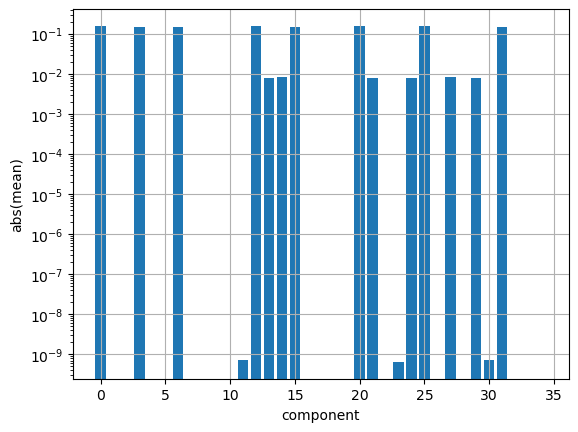

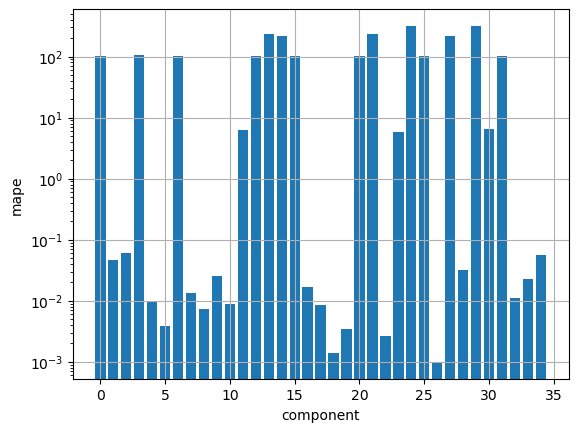

In [17]:
import matplotlib.pyplot as plt
component_abs_means = np.mean(np.absolute(test_outputs_vecs), axis=0)
print(component_abs_means)
print(np.where(component_abs_means == 0))

#Abs(Mean)
plt.figure()
plt.bar(range(len(component_abs_means)), component_abs_means)
plt.xlabel('component')
plt.ylabel('abs(mean)')
plt.grid()
plt.yscale('log')

#MAPE
plt.figure()
plt.bar(range(len(component_mapes)), component_mapes)
plt.xlabel('component')
plt.ylabel('mape')
plt.grid()
plt.yscale('log')

In [ ]:
# Compute exterior derivative of 3-forms over the test data
# Retrieve the Kahler form for the test dataset
test_kahler_form = test_dataset.kahler_form

# Compute d\phi
dg2_3form = np.array(exterior_derivative(loaded_model, test_linkpts_tf, test_patch_idxs))
print(f'G2 3-form exterior derivatives computed... (shape: {dg2_3form.shape})')
###print(f'Non-zero elements: {np.sum(np.where(np.absolute(np.mean(dg2_3form[0],axis=0)) < 1e-5, 1, 0))} / {np.prod(dg2_3form.shape[2:])}')

# Compute omega ^ omega
omega_wedge_omega = np.array([wedge_product(test_kahler_form[idx], test_kahler_form[idx]) for idx in range(test_kahler_form.shape[0])])
print(f'\omega ^ \omega computed... (shape: {omega_wedge_omega.shape})')

# Check whether dg2_3form == omega_wedge_omega
tolerance = 1e3-6
print(f'Checking identity d\phi = \omega ^ \omega:\t{np.allclose(dg2_3form, omega_wedge_omega)}')


In [ ]:
# Compute exterior derivative of 3-forms over the test data
# Retrieve the Kahler form for the test dataset
test_kahler_form = test_dataset.kahler_form

# Compute d\phi - use the GlobalModel directly (no .model attribute needed)
dg2_3form = np.array(exterior_derivative(loaded_model, test_linkpts_tf, test_patch_idxs))
print(f'G2 3-form exterior derivatives computed... (shape: {dg2_3form.shape})')
###print(f'Non-zero elements: {np.sum(np.where(np.absolute(np.mean(dg2_3form[0],axis=0)) < 1e-5, 1, 0))} / {np.prod(dg2_3form.shape[2:])}')

# Compute omega ^ omega
omega_wedge_omega = np.array([wedge_product(test_kahler_form[idx], test_kahler_form[idx]) for idx in range(test_kahler_form.shape[0])])
print(f'\omega ^ \omega computed... (shape: {omega_wedge_omega.shape})')

# Check whether dg2_3form == omega_wedge_omega
tolerance = 1e3-6
print(f'Checking identity d\phi = \omega ^ \omega:\t{np.allclose(dg2_3form, omega_wedge_omega)}')
im_hvf_wedge_dtheta = np.array([wedge_product(test_hvf_i_R7[i], test_dataset.dthetas[i]) for i in range(test_hvf_i_R7.shape[0])])
# Full \psi
psi_v2 = 0.5 * omega_wedge_omega + im_hvf_wedge_dtheta

print(psi_v2.shape)

In [ ]:
########################################################################################
### IGNORE BELOW ###

In [ ]:
###manual checking -- deleteee
#np.sum(np.where(np.absolute(omega_wedge_omega) > 1e-8, 1, 0)),np.sum(np.where(np.absolute(dg2_3form) > 1e-8, 1, 0))
#print(np.min(dg2_3form), np.mean(dg2_3form), np.max(dg2_3form))
#print(np.min(omega_wedge_omega), np.mean(omega_wedge_omega), np.max(omega_wedge_omega))

'''
for pt_idx in range(identity_test_size):
    print(np.mean(np.absolute(dg2_3form[0][pt_idx] - omega_wedge_omega[pt_idx])))
    ###reduce to non-zero?
    #--> consistently baddd
'''

print(np.mean(test_linkpts, axis=0), np.std(test_linkpts, axis=0))


In [ ]:
###testinggg
from geometry.geometry import wedge_product, wedge_form2_with_form1
fake_batchsize = 10
'''#tf
fake_2_forms = tf.random.normal((fake_batchsize, 6, 6))
fake_2_forms = fake_2_forms - tf.transpose(fake_2_forms, perm=[0, 2, 1])
fake_1_forms = tf.random.normal((fake_batchsize, 7))
'''
#np
fake_2_forms = np.random.randn(fake_batchsize, 6, 6)
fake_2_forms_66 = fake_2_forms - np.transpose(fake_2_forms, axes=[0, 2, 1])
fake_2_forms_77 = np.pad(fake_2_forms_66, ((0,0), (0,1), (0,1)), mode='constant')
fake_1_forms = np.random.normal(size=(fake_batchsize, 7))
print(f'Data shapes: {fake_2_forms.shape}, {fake_1_forms.shape}')

# old functionality:
output_old = wedge_form2_with_form1(fake_2_forms_66, fake_1_forms)
output_new = np.array([wedge_product(fake_2_forms_77[idx], fake_1_forms[idx]) for idx in range(fake_1_forms.shape[0])])

# scale output_old to match output_new
output_old *= 3 ###why is there this factor of 3 difference?

print(f'Output shapes: {output_old.shape}, {output_new.shape}')
print(f'Matching?? --> {np.allclose(output_old, output_new)}')